# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

# Observations

#### Trends
* Based on the data sets, it can be concluded that temperature significantly increases at latitudes closer to the equator. This can be observed in the 3 scatter plots showing the spread of City Latitude vs. Max Temperature for cities in the Northern Hemisphere, Southern Hemisphere, and Globally. The trend is especially noticeable in the scatter plot of the Northern Hemisphere, where points are clustered close to the regression line. The scatter plot for the Southern Hemisphere shows a greater spread of data points from the regression line, but the trend is still present. 
* Additionally, humidity seems to be inversely related to distance from the equator, depending on which hemisphere is being observed. In the Southern Hemisphere, humidity tends to increase with proximity to the equator, while in the Northern Hemisphere humidity tends to decrease with greater distance from the equator. This trend can be observed in the 2 scatter plots showing the spread of City Latitude vs. Humidity for the Northern Hemisphere and Southern Hemisphere. However, for both plots, it is important to note that the data points are spread widely from the regression line, so the trend does not have a strong correlation. Lower humidity at higher latitude in the Northern Hemisphere may be due to the data being taken during the winter, when climates are generally drier.
* Finally, wind speed also tends to decrease with proximity to the equator, as evidenced by the 2 scatter plots showing City Latitude vs. Wind Speed for the Northern and Southern Hemispheres. As with humidity, the correlation is not very strong.

#### Considerations
* This data was taken on March 15, 2020, which is late winter in the Northern Hemisphere and late summer in the Southern Hemisphere. Consequently, max temperatures skew higher in the Southern Hemisphere and skew lower in the Northern Hemisphere. 
* This data collects temperatures based on the geo-coordinates of cities. As much of the Southern Hemisphere is covered by ocean and as there are no cities in Antarctica, there were fewer data points collected for the Southern Hemisphere than for the Northern Hemisphere. The data set could be further improved by including geo-coordinates within Antarctica and islands of the South Pacific.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress
from itertools import islice 
import math
from datetime import datetime
from datetime import date


# OpenWeatherMap API Key
weather_api_key = "ec51117b472c7864c7f6e02bd56bea64"

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))
print(cities)

636
['tasiilaq', 'kruisfontein', 'saint george', 'yerbogachen', 'jamestown', 'nanortalik', 'nouakchott', 'geraldton', 'albany', 'port macquarie', 'taolanaro', 'adrar', 'puerto ayora', 'satitoa', 'rafraf', 'hithadhoo', 'hilo', 'sarkand', 'balykshi', 'najran', 'samusu', 'pisco', 'san patricio', 'kagadi', 'punta arenas', 'yeniseysk', 'iquique', 'vostok', 'upernavik', 'igarka', 'kavieng', 'ushuaia', 'illoqqortoormiut', 'rikitea', 'mataura', 'kapaa', 'barrow', 'busselton', 'bandarbeyla', 'kodiak', 'vanimo', 'petukhovo', 'lebu', 'longyearbyen', 'chokurdakh', 'odweyne', 'lop buri', 'codrington', 'klaksvik', 'mandiana', 'khatanga', 'port elizabeth', 'lagoa', 'avarua', 'zhigansk', 'lata', 'oistins', 'kumba', 'manaus', 'sa kaeo', 'atuona', 'new norfolk', 'airai', 'dingle', 'la ronge', 'puerto carreno', 'tazovskiy', 'ondorhaan', 'vaini', 'flinders', 'sao filipe', 'bairiki', 'salalah', 'georgetown', 'hermanus', 'hobart', 'bethel', 'lethem', 'plonsk', 'bluff', 'quatre cocos', 'saint-philippe', 'den

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Define function to create a dictionary containing weather data 
# for a single city, and append it to the dictionary.
def create_city_dict(city):
    # Create a list to hold weather data for a single city
    city_weather = []

    # Save config information
    url = "http://api.openweathermap.org/data/2.5/weather?"

    # Build query URL
    query_url = f"{url}appid={weather_api_key}&q={city}&units=Imperial"

    # Read JSON data to call the Open Weather Map API.
    weather_response = requests.get(query_url)
    weather_json = weather_response.json()

    # Set variables to hold relevant data
    city_name = weather_json["name"]
    lat = weather_json["coord"]["lat"]
    lon = weather_json["coord"]["lon"]
    max_temp = weather_json["main"]["temp_max"]
    cloud = weather_json["clouds"]["all"]
    wind_speed = weather_json["wind"]["speed"]
    humidity = weather_json["main"]["humidity"]
    date = weather_json["dt"]
    id_code = weather_json["id"]
    country = weather_json["sys"]["country"]

    # Append variables to list
    city_weather.append(city_name)
    city_weather.append(cloud)
    city_weather.append(country)
    city_weather.append(date)
    city_weather.append(humidity)
    city_weather.append(lat)
    city_weather.append(lon)
    city_weather.append(max_temp)
    city_weather.append(wind_speed)

    return city_weather

In [4]:
# Create a dictionary to hold each city name as a key
# and a list of city weather data as values
all_cities_weather = {}

# Perform a loop of API calls cities
try:
    # Loop through x groups of 50 cities.  
    # If number of cities is not divisible by 50, 
    # then the last group will raise an IndexError. 
    # Raise an Exception IndexError to terminate the loop.
    for x in range(0, math.floor(len(cities)/50+1)):

        # Loop through each set of 50 cities
        for y in range(0, 49):
            
            try:
                # Create a variable to hold weather data for that city.
                city = create_city_dict(cities[x*50+y])   
    
                # Update all_cities_weather dictionary to include data for that city
                all_cities_weather.update({cities[x*50+y]:city})
    
                # Print index number of city, index number of groups, and name of city
                print(f"Processing Record {y+1} of Set {x+1} | {cities[x*50+y]}")

            # If city name is not in Open Weather API list of cities, 
            # raise an Exception to print City not found.
            except KeyError:
                print("City not found. Skipping...")

        # Delay 15 seconds between API calls
        time.sleep(15)
    
    # Exception IndexError to terminate the loop.
except IndexError:
    print(f"------------------------------") 
    print(f"Data Retrieval Complete") 
    print(f"------------------------------")

Processing Record 1 of Set 1 | tasiilaq
Processing Record 2 of Set 1 | kruisfontein
Processing Record 3 of Set 1 | saint george
Processing Record 4 of Set 1 | yerbogachen
Processing Record 5 of Set 1 | jamestown
Processing Record 6 of Set 1 | nanortalik
Processing Record 7 of Set 1 | nouakchott
Processing Record 8 of Set 1 | geraldton
Processing Record 9 of Set 1 | albany
Processing Record 10 of Set 1 | port macquarie
City not found. Skipping...
Processing Record 12 of Set 1 | adrar
Processing Record 13 of Set 1 | puerto ayora
City not found. Skipping...
Processing Record 15 of Set 1 | rafraf
Processing Record 16 of Set 1 | hithadhoo
Processing Record 17 of Set 1 | hilo
Processing Record 18 of Set 1 | sarkand
City not found. Skipping...
Processing Record 20 of Set 1 | najran
City not found. Skipping...
Processing Record 22 of Set 1 | pisco
Processing Record 23 of Set 1 | san patricio
Processing Record 24 of Set 1 | kagadi
Processing Record 25 of Set 1 | punta arenas
Processing Record 2

Processing Record 11 of Set 5 | ketchikan
City not found. Skipping...
Processing Record 13 of Set 5 | teguldet
Processing Record 14 of Set 5 | cabo san lucas
Processing Record 15 of Set 5 | manggar
Processing Record 16 of Set 5 | mandalgovi
Processing Record 17 of Set 5 | viedma
Processing Record 18 of Set 5 | mazurivka
Processing Record 19 of Set 5 | pelym
Processing Record 20 of Set 5 | porto walter
Processing Record 21 of Set 5 | gazanjyk
Processing Record 22 of Set 5 | roald
Processing Record 23 of Set 5 | killam
City not found. Skipping...
Processing Record 25 of Set 5 | yar-sale
Processing Record 26 of Set 5 | marabba
Processing Record 27 of Set 5 | tiksi
Processing Record 28 of Set 5 | zhuanghe
City not found. Skipping...
Processing Record 30 of Set 5 | tiznit
Processing Record 31 of Set 5 | plettenberg bay
Processing Record 32 of Set 5 | asbestos
Processing Record 33 of Set 5 | ahipara
Processing Record 34 of Set 5 | te anau
Processing Record 35 of Set 5 | zyryanka
City not fou

Processing Record 23 of Set 9 | anito
Processing Record 24 of Set 9 | akureyri
Processing Record 25 of Set 9 | stillwater
Processing Record 26 of Set 9 | lasa
Processing Record 27 of Set 9 | arcata
Processing Record 28 of Set 9 | keti bandar
Processing Record 29 of Set 9 | hernani
City not found. Skipping...
Processing Record 31 of Set 9 | petropavlovsk-kamchatskiy
Processing Record 32 of Set 9 | saint-augustin
Processing Record 33 of Set 9 | bushehr
Processing Record 34 of Set 9 | havoysund
Processing Record 35 of Set 9 | nakamura
Processing Record 36 of Set 9 | abonnema
Processing Record 37 of Set 9 | tateyama
Processing Record 38 of Set 9 | aswan
Processing Record 39 of Set 9 | poum
Processing Record 40 of Set 9 | daru
Processing Record 41 of Set 9 | baykit
Processing Record 42 of Set 9 | muravlenko
Processing Record 43 of Set 9 | virginia beach
Processing Record 44 of Set 9 | myaundzha
Processing Record 45 of Set 9 | monywa
Processing Record 46 of Set 9 | sandy bay
City not found. 

Processing Record 30 of Set 13 | dalnegorsk
Processing Record 31 of Set 13 | sekondi
Processing Record 32 of Set 13 | bilgoraj
Processing Record 33 of Set 13 | lucea
Processing Record 34 of Set 13 | bocas del toro
Processing Record 35 of Set 13 | ndola
Processing Record 36 of Set 13 | apple valley
------------------------------
Data Retrieval Complete
------------------------------


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# Convert all_cities_weather dictionary to a DataFrame
Summary = pd.DataFrame.from_dict(all_cities_weather, orient="index")

# Rename the DataFrame columns
Summary = Summary.rename(columns=
                        {0:"City",
                        1:"Cloudiness",
                        2:"Country",
                        3:"Date",
                        4:"Humidity",
                        5:"Lat",
                        6:"Lng",
                        7:"Max Temp",
                        8:"Wind Speed"}
                        )
# Reset index.
Summary = Summary.reset_index(drop=True)

# Display head
Summary.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,Tasiilaq,100,GL,1584332762,51,65.61,-37.64,10.40,16.11
1,Kruisfontein,100,ZA,1584332493,88,-34.00,24.73,60.33,10.02
2,Saint George,1,US,1584332484,66,37.10,-113.58,57.99,8.05
3,Yerbogachën,100,RU,1584332762,93,61.28,108.01,31.19,14.45
4,Jamestown,1,US,1584332639,53,42.10,-79.24,28.00,9.17


In [6]:
# Export DatFrame to CSV
Summary.to_csv("Output/CityWeatherData.csv", index=False)

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [7]:
# Set variable to date data was taken

# Pull time stamp from one of the cities in the data set
timestamp = Summary.iloc[0, 3]

# Convert time stamp to date
data_date = date.fromtimestamp(timestamp)

# Format date in MM/DD/YY
formatted_date = data_date.strftime("%m/%d/%y")

#### Latitude vs. Temperature Plot

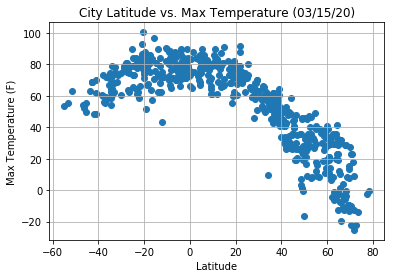

In [8]:
# Set x and y values
x_values=Summary["Lat"]
y_values=Summary["Max Temp"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"City Latitude vs. Max Temperature ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

# Add grid
plt.grid()

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Global_Latitude_vs_Temp.png")

# Show plot
plt.show()


#### Latitude vs. Humidity Plot

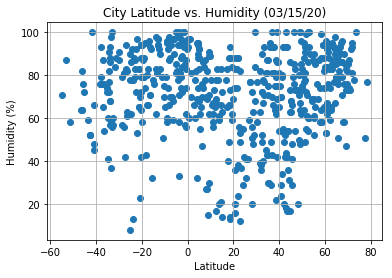

In [9]:
# Set x and y values
x_values=Summary["Lat"]
y_values=Summary["Humidity"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"City Latitude vs. Humidity ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

# Add grid
plt.grid()

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Global_Latitude_vs_Humidity.png")

# Show plot
plt.show()

#### Latitude vs. Cloudiness Plot

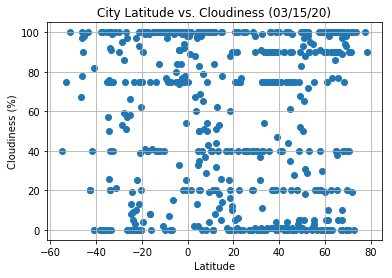

In [10]:
# Set x and y values
x_values=Summary["Lat"]
y_values=Summary["Cloudiness"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"City Latitude vs. Cloudiness ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Add grid
plt.grid()

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Global_Latitude_vs_Cloud.png")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

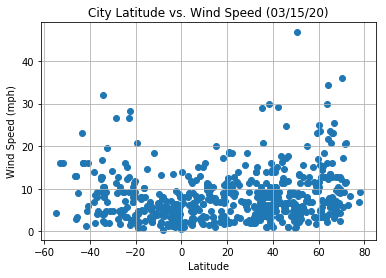

In [11]:
# Set x and y values
x_values=Summary["Lat"]
y_values=Summary["Wind Speed"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"City Latitude vs. Wind Speed ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

# Add grid
plt.grid()

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Global_Latitude_vs_Wind.png")

# Show plot
plt.show()

## Linear Regression

In [12]:
# OPTIONAL: Create a function to create Linear Regression plots
def regression_plot(latitude, weather):
    # Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen

    # Set x and y values of scatterplot
    x_values = latitude
    y_values = weather

    # Apply linear regression formula. Set line of linear regression.
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept

    # Write equation of regression line
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    print(f"The r-squared is {rvalue}.")
    return  plt.plot(x_values,regress_values,"r-"), plt.annotate(line_eq, (10,100), fontsize=15, color="red", xycoords="axes points")

In [13]:
# Create Northern and Southern Hemisphere DataFrames
northern = Summary.loc[(Summary["Lat"]>0),:]
southern = Summary.loc[(Summary["Lat"]<0),:]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is -0.8975094806893931.


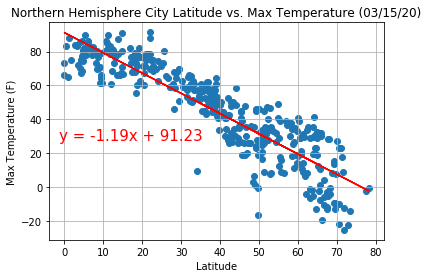

In [14]:
# Set x and y values
x_values=northern["Lat"]
y_values=northern["Max Temp"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Northern Hemisphere City Latitude vs. Max Temperature ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/North_Latitude_vs_Temp.png")

# Show plot
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is 0.5482909419461519.


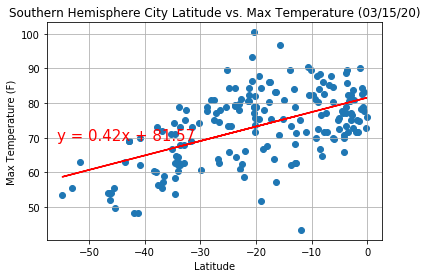

In [15]:
# Set x and y values
x_values=southern["Lat"]
y_values=southern["Max Temp"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Southern Hemisphere City Latitude vs. Max Temperature ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/South_Latitude_vs_Temp.png")

# Show plot
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is 0.21357443935010426.


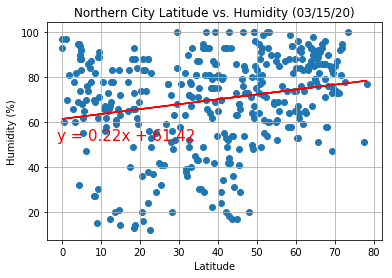

In [16]:
# Set x and y values
x_values=northern["Lat"]
y_values=northern["Humidity"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Northern City Latitude vs. Humidity ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/North_Latitude_vs_Humidity.png")

# Show plot
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is 0.28789814293497645.


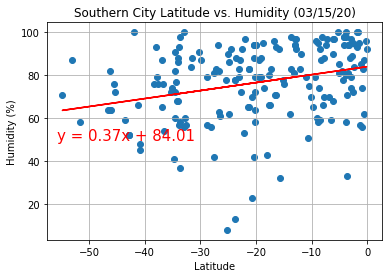

In [17]:
# Set x and y values
x_values=southern["Lat"]
y_values=southern["Humidity"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Southern City Latitude vs. Humidity ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/North_Latitude_vs_Humidity.png")

# Show plot
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is 0.08604567071610963.


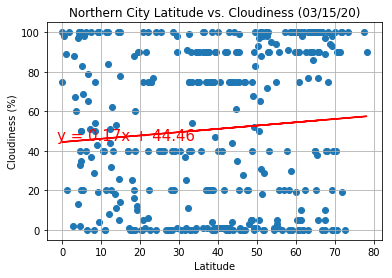

In [18]:
# Set x and y values
x_values=northern["Lat"]
y_values=northern["Cloudiness"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Northern City Latitude vs. Cloudiness ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/North_Latitude_vs_Cloud.png")

# Show plot
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is 0.25117940876506156.


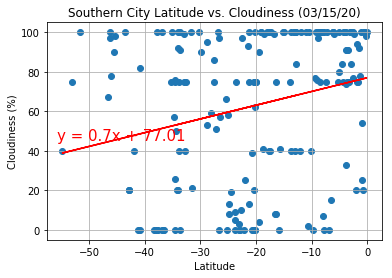

In [19]:
# Set x and y values
x_values=southern["Lat"]
y_values=southern["Cloudiness"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Southern City Latitude vs. Cloudiness ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/South_Latitude_vs_Cloud.png")

# Show plot
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is 0.22472503599135918.


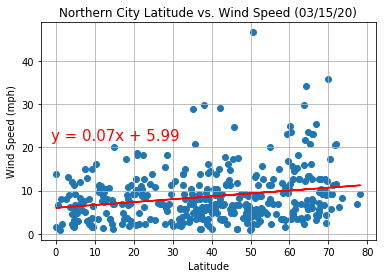

In [20]:
# Set x and y values
x_values=northern["Lat"]
y_values=northern["Wind Speed"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Northern City Latitude vs. Wind Speed ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Northern_Latitude_vs_Wind.png")

# Show plot
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is -0.3971400804925312.


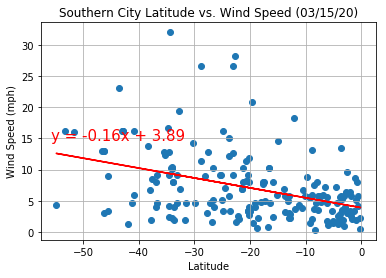

In [21]:
# Set x and y values
x_values=southern["Lat"]
y_values=southern["Wind Speed"]

# Build plot
plt.scatter(x_values, y_values)

# Set title and axis labels
plt.title(f"Southern City Latitude vs. Wind Speed ({formatted_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

# Add grid
plt.grid()

# Show equation for linear regression line
regression_plot(x_values, y_values)

# Create figure and export
fig4 = plt.gcf()
fig4.savefig("Output/Figures/Southern_Latitude_vs_Wind.png")

# Show plot
plt.show()